In [36]:
import fenics as fe
from fenics import inner, grad, div, det, rot, dot, tr

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'

import ipywidgets as ipw

from pyamg.util import condest, cond
import numpy as np

In [37]:
mesh = fe.Mesh( '../geo/muscle_2d.xml')
#mesh = fe.refine(mesh)

L0 = 1e-2

coords = mesh.coordinates()
coords *= L0
mesh.bounding_box_tree().build(mesh)


# Init function spaces
element_disp = fe.VectorElement("P", mesh.ufl_cell(), 2)
element = fe.FiniteElement("P", mesh.ufl_cell(), 1)

# Mixed function space
TH = element * element_disp
V = fe.FunctionSpace(mesh, TH)
V_p = fe.FunctionSpace(mesh, element)
V_disp = fe.FunctionSpace(mesh, element_disp)

# Define Boundaries
left =  fe.CompiledSubDomain("near(x[1], side, 0.01) && on_boundary", side = -20.0*L0)
right = fe.CompiledSubDomain("near(x[1], side, 0.01) && on_boundary", side = 20.0*L0)

# Define acting force
b = fe.Expression(("scale*gravity", "0."), scale=0., gravity=9.81, element=element_disp)       # Body force per unit volume
t_bar  = fe.Constant((0.0,  0.0))   # Traction force on the boundary


d = 2

# Initialize mesh function for boundary domains
boundaries = fe.MeshFunction('size_t', mesh, d - 1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)


# Define Dirichlet boundary (x = 0 or x = 1)
u_left = fe.Expression(("0.0", "0.0"), element=element_disp)
u_right = fe.Expression(("1.*scale", "0.0"), scale=0., element=element_disp)
p_left = fe.Constant(0.)

bcul = fe.DirichletBC(V.sub(1), u_left, left, method="geometric")
bcur = fe.DirichletBC(V.sub(1), u_right, right)
bcs = [bcul, bcur]

# Define new measures associated with the interior domains and
# exterior boundaries

dx = fe.Measure('dx', domain=mesh)
ds = fe.Measure('ds', domain=mesh, subdomain_data=boundaries)


# Define test and trial functions
w = fe.Function(V)  # most recently computed solution
(p, u) = fe.split(w)
(q, v) = fe.TestFunctions(V)
dw = fe.TrialFunction(V)

In [38]:
# Mooney-Rivlin parameters (in Pa)
# parameters taken from O. Roehrle and Heidlauf
#c_10 = fe.Constant(6.352e4)
#c_01 = fe.Constant(3.627e3)
c_10 = fe.Constant(1e4)
c_01 = fe.Constant(2e3)
b_1 = 2.756e-5
d_1 = 43.373
p_max = 73.0
f_s = 50.  # stimulation frequency (in Hz)

# Not found
rho = fe.Constant(1.1e6)
kappa = fe.Constant(1e8)
compr = fe.Constant(1.)



# currently simplifications
p_act = fe.Expression("p_max*p_act*scale", p_act=1., p_max=73e3, scale=0., degree=0)
lmb_f = fe.Constant(1.)

In [39]:
# Kinematics
I = fe.Identity(d)             # Identity tensor

F = fe.variable(I + grad(u))  # Deformation gradient
C = fe.variable(F.T*F)  # Right Cauchy-Green tensor
J = fe.det(C)**0.5

DE = lambda v: 0.5*(F.T*grad(v) + grad(v).T*F)

a_0 = fe.as_vector([[0.0], [1.0]])
A_00 = dot( a_0, a_0.T )

# Invariants
I_1 = tr(C) + 1
I_2 = 0.5*((tr(C)+1)**2 - (tr(C*C)+1))

I_4 = dot(a_0.T, C*a_0)


I1_ = J**(-2./3.)*I_1
I2_ = J**(-4./3.)*I_2

W_iso = c_10*(I1_ - 3) + c_01*(I2_ - 3) - p*(J-1) - compr*p**2/2*kappa

#P_iso = fe.diff(W_iso, F)
S_iso = 2.*fe.diff(W_iso,C)

S_passive = lmb_f**(-1)*p_act*A_00
S_ani = b_1 * ( lmb_f**(d_1-2) - lmb_f**(-2) ) * A_00

S = S_iso + S_passive + S_ani

F_static = inner(S, DE(v))*dx - rho*inner(b, v)*dx - inner(t_bar, v)*ds(2) + (compr*p/kappa + (J-1))*q*dx

In [40]:
# solve static case

J_static = fe.derivative(F_static, w, dw)

ffc_options = {"optimize": True}
problem = fe.NonlinearVariationalProblem(F_static, w, bcs, J=J_static, form_compiler_parameters=ffc_options)
solver = fe.NonlinearVariationalSolver(problem)

In [41]:
w_steady = fe.Function(V) 

def demo_plt(scale=0.,kappa_exp=4.,incompr=False):

    #print("working...", end="\r")
    p_act.scale = scale
    kappa.assign( fe.Constant(10**kappa_exp) )
    if incompr:
        compr.assign(fe.Constant(0.))
    else:
        compr.assign(fe.Constant(1.))
    solver.solve()
    
    plt.subplot(121)
    w_plt = fe.plot(w.sub(1), mode='displacement')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.subplot(122)
    w_plt = fe.plot(w.sub(0))
    plt.gca().set_aspect('equal', adjustable='box')
    
    w_steady.assign(w)
    
    J_mat = fe.assemble(J_static)
    J_np = np.matrix(J_mat.array())
    #print("done!     ")
    #print(np.log10(condest(J_np, maxiter=100)))

    
w.assign(fe.Function(V))
plt_wdg = ipw.interact( demo_plt, scale=ipw.FloatSlider(min=0,max=1,step=0.05,value=0), 
             kappa_exp=ipw.IntSlider(min=1,max=18,value=6),
             incompr = ipw.Checkbox())

# Adjust widget height to prevent flickering
output = plt_wdg.widget
output.layout.height = '450px'

interactive(children=(FloatSlider(value=0.0, description='scale', max=1.0, step=0.05), IntSlider(value=6, desc…

In [103]:
solver.solve()

(0, 1)

In [104]:
# time integration, use previously computed steady state as initial value

# explicit time integration!
t_end = 1.
dt = 0.1

w_hist = [w]


while t < t_end:    
    w

In [105]:
F_mat = fe.assemble(F_static)

In [106]:
J_mat = fe.assemble(J_static)
J_np = np.matrix(J_mat.array())
condest(J_np, maxiter=100)

35989857.719407365

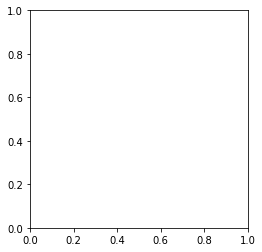

In [107]:
fe.plot(w_steady.sub(0), mode="displacement")

In [108]:
# Init function spaces
element_disp = fe.VectorElement("P", mesh.ufl_cell(), 2)
element_vel = fe.VectorElement("P", mesh.ufl_cell(), 2)

# Mixed function space
TH = fe.MixedElement([element, element_disp, element_vel]) 
V_td = fe.FunctionSpace(mesh, TH)
V_1 = fe.FunctionSpace(mesh, element)
V_disp = fe.FunctionSpace(mesh, element_disp)
V_vel = fe.FunctionSpace(mesh, element_vel)

def add_zero_vel(v):
    w = fe.Function(V_td)
    fe.assign( w.sub(0), v.sub(0) )
    fe.assign( w.sub(1), v.sub(1) )
    return w   


In [119]:
# Define test and trial functions
(ptr, utr, vtr) = fe.TrialFunctions(V_td)
(pts, uts, vts) = fe.TestFunctions(V_td)

w_last = add_zero_vel(w_steady)
(pl, ul, vl) = fe.split(w_last)

# Kinematics
I = fe.Identity(d)             # Identity tensor

F = fe.variable(I + grad(ul))  # Deformation gradient
C = fe.variable(F.T*F)  # Right Cauchy-Green tensor
J = fe.det(C)**0.5  # note: this step is important, to get the correct derivative, J depends on C as it depends on F.

a_0 = fe.as_vector([[0.], [1.]])
A_00 = dot( a_0, a_0.T )

# Invariants
I_1 = tr(C) + 1
I_2 = 0.5*((tr(C)+1)**2 - (tr(C*C)+1))
I_4 = dot(a_0.T, C*a_0)

I1_ = J**(-2./3.)*I_1
I2_ = J**(-4./3.)*I_2

lag_mult = fe.Constant(0.)

W_iso = c_10*(I1_ - 3) + c_01*(I2_ - 3)  # - lag_mult*p*(J-1) - lag_mult*compr*p**2/2*kappa

S_iso = 2.*fe.diff(W_iso,C)

S_passive = lmb_f**(-1)*p_act*A_00
S_ani = b_1 * ( lmb_f**(d_1-2) - lmb_f**(-2) ) * A_00

S = S_iso  # + S_passive + S_ani

dt = fe.Constant(0.0001)
t_end = 1e2*float(dt)


DE = lambda v: 0.5*(F.T*grad(v) + grad(v).T*F)

F_stat = inner(S, DE(uts))*dx - rho*inner(b, uts)*dx - inner(t_bar, uts)*ds(2)
F_dyn_vel = rho*inner(vtr - vl, uts)*dx + ptr*pts*dx + F_stat

F_dyn_pos = inner(utr - ul, vts)*dx - inner(vl, vts)*dx

F_dyn = F_dyn_vel + F_dyn_pos



a_v = fe.lhs(F_dyn_vel)
L_v = fe.rhs(F_dyn_vel)


a_p = fe.lhs(F_dyn_pos)
L_p = fe.rhs(F_dyn_pos)

compr.assign(fe.Constant(1.))
kappa.kappa = 1e0


w_hist = [fe.Function(V_td)]
w_hist[-1].assign(w_last)

w_next = fe.Function(V_td)

f = ipw.FloatProgress(min=0, max=t_end) # instantiate the bar
display(f) # display the bar


bcul_td = fe.DirichletBC(V_td.sub(1), u_left, left, method="geometric")
bcur_td = fe.DirichletBC(V_td.sub(1), u_right, right)
bcs_td = [bcul_td, bcur_td]

freq = 0.

t = 0
while t < t_end:
    
    #p_act.scale = 0.5 - 0.5*np.cos(2*t*fe.pi*freq*t)
    
    fe.solve(a==L, w_next, bcs_td)
    
    w_slast.assign(w_last)
    w_last.assign(w_next)
    
    w_hist.append(fe.Function(V))
    w_hist[-1].assign(w_last)
    
    t += float(dt)
    f.value = t

FloatProgress(value=0.0, max=0.01)

In [120]:
def show_time(t):
    
    i = int(np.floor(t/float(dt)))
    i = max(0, min(len(w_hist)-1, i))
        
    plt.subplot(121)
    w_plt = fe.plot(w_hist[i].sub(1), mode="displacement")
    plt.colorbar(w_plt)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.subplot(122)
    p_plt = fe.plot(w_hist[i].sub(0))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(w_plt)
    
    
    
ipw.interact( show_time, t=ipw.FloatSlider(min=0,max=t_end,step=float(dt),value=0))

interactive(children=(FloatSlider(value=0.0, description='t', max=0.01, step=0.0001), Output()), _dom_classes=…

<function __main__.show_time(t)>

In [114]:
mesh.hmin(), mesh.hmax()

(1.137007198985262, 3.1783602617257527)

In [ ]:
fe.plot(w_steady.sub(0), mode="displacement")
plt.show()
fe.plot(w_hist[0].sub(0), mode="displacement")

In [35]:
w_hist[1]

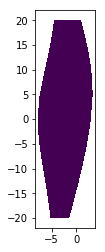

In [65]:
fe.plot(w_steady.sub(0), mode="displacement")

In [ ]:
plt.spy(A_mat)

In [ ]:
form = dp*2*q*dx(mesh)


In [ ]:
form_action = fe.action(form, dw)

In [ ]:
from_mat = np.matrix( fe.assemble(form_action).array())

In [ ]:
from_mat.shape